In [1]:
import pandas as pd
import numpy as np
import math

from datetime import datetime

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import figure

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Funciones de ingeniería de características.

In [3]:
def add_categ_range_col(df, col, method='quantile',
                        thresholds=None, labels=('bajo','medio','alto')):
    """
    Agrega columna '{col}_range' con categorías (bajo/medio/alto).
    - method: 'quantile' usa cuantiles [0, .5, 1] si thresholds es None.
    - thresholds: lista de bin edges [min, t1, t2, max].
    """
    series = df[col]
    if thresholds is None and method=='quantile':
        q = series.quantile([0, .33, .66, 1]).values
        bins = q
    else:
        bins = thresholds
    df[f'{col}_range'] = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return df

def add_pareto_front(df, x='time_duration', y='total_reward',
                     minimize_x=True, maximize_y=True,
                     labels=('front_1','front_2','front_3')):
    """
    Aplica non-dominated sorting para hasta 3 fronts.
    Crea columna 'pareto_label' con etiqueta de front.
    """
    data = df[[x, y]].values
    n = data.shape[0]
    fronts = []
    dominated = np.zeros(n, dtype=bool)
    for level in range(len(labels)):
        mask = np.zeros(n, dtype=bool)
        for i in range(n):
            if dominated[i]: continue
            better = False
            for j in range(n):
                if i==j or dominated[j]: continue
                xi, yi = data[i]
                xj, yj = data[j]
                # comparar según objetivos
                better_x = (xj < xi) if minimize_x else (xj > xi)
                better_y = (yj > yi) if maximize_y else (yj < yi)
                if better_x and better_y:
                    dominated[i] = True
                    break
            else:
                mask[i] = True
        fronts.append(mask)
        dominated |= mask
        if dominated.all():
            break

    df['pareto_label'] = None
    for lvl, mask in enumerate(fronts):
        df.loc[mask, 'pareto_label'] = labels[lvl]
    return df

def top_n_combinations(df, suffix_name='reward_and_time',
                       sort_by=('total_reward','time_duration'),
                       ascending=(False, True), n=10):
    """
    Asigna ranking global basado en sort_by:
    - ascending tuple: True=ascendente, False=descendente.
    Agrega columna 'rank_{suffix_name}' y devuelve top n rows.
    """
    col_rank = f'rank_{suffix_name}'
    df_sorted = df.sort_values(list(sort_by), ascending=list(ascending)).copy()
    df_sorted[col_rank] = np.arange(1, len(df_sorted)+1)
    return df_sorted.head(n)

# Funciones para visualización

In [5]:
plot_config = {
    'figsize': (16, 12),    # tamaño de la figura
    'tick_fontsize': 22,   # tamaño fuente ticks
    'xtick_rotation': 0,  # rotación etiquetas eje X
    'palette': 'deep',     # paleta seaborn
    'grid_on': True,       # mostrar grid
    'save_path': ''   # ruta para guardar figuras
}

In [6]:
def plot_3d_scatter(df, x='final_kd', y='final_ki', z='final_kp',
                    color='total_reward', marker_by=None,
                    config=plot_config, save_fig=False, elev=30, azim=45, cbar_shrink=0.5,
                    cbar_label='Total reward [-]',
                    cbar_vmin = None,
                    cbar_vmax = None,
                    margin={'left':0.3}):
    """Gráfico 3D con color continuo y posibilidad de marcador por categoría"""
    title = '3D scatter plot of PID gain combinations.'
    xlabel = r'$k_d$'
    ylabel = r'$k_i$'
    zlabel = r'$k_p$'
    fig = plt.figure(figsize=config['figsize'])
    ax = fig.add_subplot(111, projection='3d')
    plt.setp(ax.get_xticklabels(), fontsize=config['tick_fontsize'])
    plt.setp(ax.get_yticklabels(), fontsize=config['tick_fontsize'])
    plt.setp(ax.get_zticklabels(), fontsize=config['tick_fontsize'])
    ax.view_init(elev=elev, azim=azim)
    
    sc = ax.scatter(df[x], df[y], df[z], c=df[color], cmap='plasma')
    
    if cbar_vmin and cbar_vmax:
        sc.set_clim(vmin=cbar_vmin, vmax=cbar_vmax)
    else:
        sc.set_clim(vmin=df[color].min(), vmax=df[color].max())
        
    cb = plt.colorbar(sc, ax=ax,
                      shrink=cbar_shrink, pad=0.0005)
    
    if cbar_label:
        cb.set_label(cbar_label, fontsize=18, labelpad=10)
        
    if marker_by:
        for m in df[marker_by].unique():
            idx = df[marker_by] == m
            ax.scatter(df.loc[idx, x], df.loc[idx, y], df.loc[idx, z], label=m, edgecolor='k', alpha=0.7)
        ax.legend()
        
    ax.set_title(title, fontsize=24, y=0.95)
    ax.set_xlabel(xlabel or x, fontsize=22, labelpad=15)
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylabel(ylabel or y, fontsize=22, labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(zlabel or z, fontsize=22, rotation=0, labelpad=10)
    
    if margin:
        fig.subplots_adjust(**margin)
    
    #fig.tight_layout()
    ax.set_box_aspect(None, zoom=0.9)
    if save_fig:
        fig.savefig(f"{config['save_path']}3d_scatter.png", bbox_inches='tight')
    plt.show()

def plot_pareto(df, x='time_duration', y='total_reward',
                minimize_x=True, maximize_y=True,
                highlight_color='red', config=plot_config, save_fig=False):
    """Dibuja puntos y resalta primer frente de Pareto"""
    title = 'Pareto front by Time duration vs Total reward'
    xlabel = 'Time duration [-]'
    ylabel = 'Total reward [-]'
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.scatter(df[x], df[y], label='Todos los puntos')
    front = df[df['pareto_label'] == 'front_1']
    ax.scatter(front[x], front[y], color=highlight_color, label='Frontera Pareto')
    ax.set_title(title)
    ax.set_xlabel(xlabel or x)
    ax.set_ylabel(ylabel or y)
    if config['grid_on']:
        ax.grid(True)
    ax.legend()
    if save_fig:
        fig.savefig(f"{config['save_path']}pareto.png", bbox_inches='tight')
    plt.show()

# Carga y preparación de datos.

In [113]:
# 1. Leer Excel
folder_name = 'results_history_WaterTank\\20250813-1220\\'
name_data_file = 'episodes_summary_data.xlsx'
df_raw = pd.read_excel(folder_name+name_data_file)
print(f"Tamaño del DataFrame: {df_raw.shape}")

Tamaño del DataFrame: (5000, 175)


In [115]:
# 2. Selección de columnas de interés
cols = ['episode', 'epsilon', 'learning_rate',
        'time_duration', 'termination_reason',
        'total_reward', 'performance',
        'final_kp', 'final_ki', 'final_kd'
        ]
df = df_raw[cols].copy()
df.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration',
       'termination_reason', 'total_reward', 'performance', 'final_kp',
       'final_ki', 'final_kd'],
      dtype='object')

In [117]:
# 3. Estadísticos generales
print("Estadísticos globales:")
df.describe().T

Estadísticos globales:


,count,mean,std,min,25%,50%,75%,max
episode,5000.0,2499.500000,1443.520003,0.000000,1249.750000,2499.500000,3749.250000,4999.000000
epsilon,5000.0,0.332602,0.251536,0.100000,0.115462,0.237070,0.486758,0.999425
learning_rate,5000.0,0.108191,0.042630,0.050005,0.070711,0.099991,0.141396,0.199945
time_duration,5000.0,5.575989,0.513720,3.587000,5.101000,6.000000,6.000000,6.000000
total_reward,5000.0,5304.458291,658.994553,1374.365940,4900.363598,5320.399983,5840.109481,6610.737743
performance,5000.0,957.142942,125.944196,229.060990,884.352497,1006.085846,1051.947168,1120.349850
final_kp,5000.0,4.496280,0.966733,0.000000,4.600000,4.800000,5.000000,5.000000
final_ki,5000.0,0.764200,0.684015,0.000000,0.400000,0.600000,0.800000,4.600000
final_kd,5000.0,0.817720,1.458440,0.000000,0.000000,0.200000,0.600000,5.000000


In [119]:
# 4. Filtrar solo episodios estabilizados
df_stable = df[df['termination_reason'] == 'goal_reached'].copy()
print(f"Tamaño tras filtrar estabilizados: {df_stable.shape}")
print("Estadísticos solo estabilizados:")
df_stable.describe().T

Tamaño tras filtrar estabilizados: (2480, 10)
Estadísticos solo estabilizados:


,count,mean,std,min,25%,50%,75%,max
episode,2480.0,3269.506855,1122.836498,5.000000,2388.750000,3364.500000,4226.250000,4999.000000
epsilon,2480.0,0.197749,0.137032,0.100000,0.100000,0.144087,0.252676,0.996552
learning_rate,2480.0,0.084928,0.028269,0.050005,0.061952,0.078671,0.103109,0.199668
time_duration,2480.0,5.145140,0.404620,3.587000,4.851000,5.101000,5.451000,5.999000
total_reward,2480.0,5375.390061,555.638948,3506.580197,5037.634307,5309.831937,5838.914428,6610.737743
performance,2480.0,1043.209956,42.548182,711.808431,1025.838106,1050.612915,1068.933806,1120.349850
final_kp,2480.0,4.852097,0.367096,0.200000,4.800000,5.000000,5.000000,5.000000
final_ki,2480.0,0.491532,0.103940,0.200000,0.400000,0.400000,0.600000,0.800000
final_kd,2480.0,0.216855,0.577113,0.000000,0.000000,0.000000,0.200000,5.000000


# Ingeniería de Datos

In [122]:
# 5. Aplicar funciones de ingeniería de características
df2 = df_stable.copy()
#df2 = add_categ_range_col(df2, col='final_kp')
df2 = add_pareto_front(df2, x='time_duration', y='total_reward')

print(f"Tamaño tras filtrar estabilizados: {df2.shape}")
display(df2.head())

Tamaño tras filtrar estabilizados: (2480, 11)


,episode,epsilon,learning_rate,time_duration,termination_reason,total_reward,performance,final_kp,final_ki,final_kd,pareto_label
5,5,0.996552,0.199668,4.851,goal_reached,3837.747417,791.125009,3.0,0.4,0.4,None
10,10,0.993688,0.199391,5.201,goal_reached,4282.282456,823.357519,0.8,0.4,1.6,None
52,52,0.969951,0.197083,5.501,goal_reached,4570.584966,830.864382,1.6,0.4,0.0,None
59,59,0.966051,0.196701,5.751,goal_reached,4798.773843,834.424247,0.8,0.4,1.0,None
66,66,0.962166,0.196319,5.151,goal_reached,4554.637785,884.223992,2.6,0.4,2.2,None


In [124]:
df2['pareto_label'].unique()

array([None, 'front_1'], dtype=object)

In [126]:
df3 = df2[df2['pareto_label'] == 'front_1'].copy()
print(f"Tamaño tras filtrar por frontera de pareto: {df3.shape}")

Tamaño tras filtrar por frontera de pareto: (203, 11)


# Análisis de Resultados

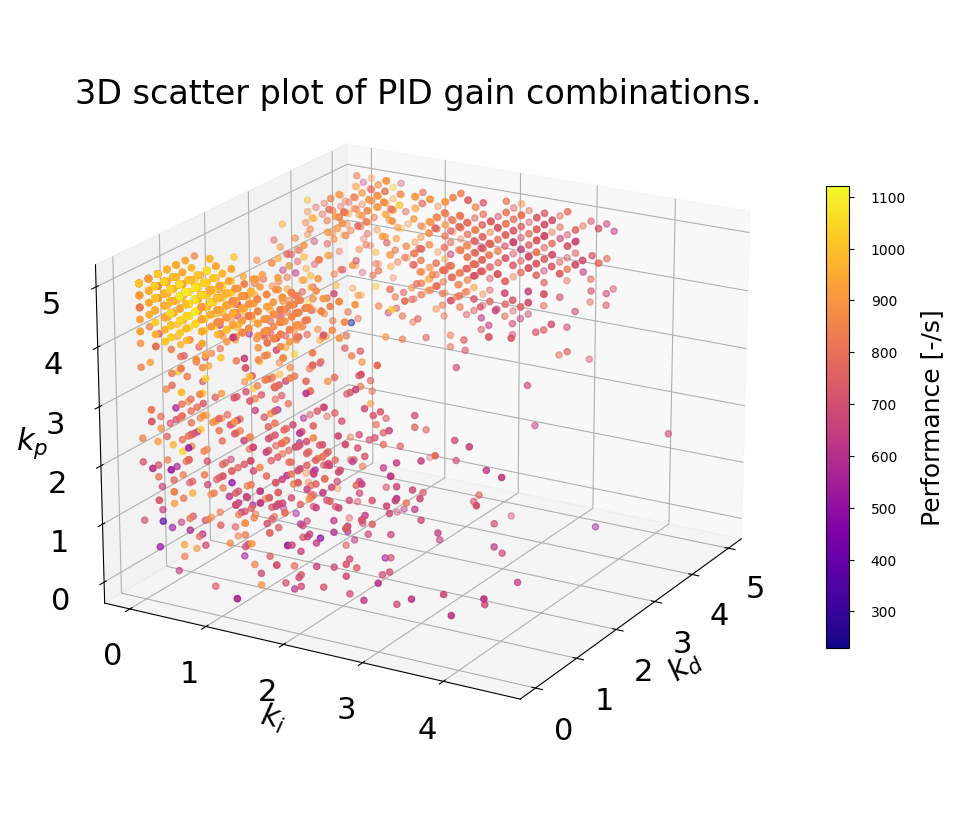

In [129]:
plot_3d_scatter(df, x='final_kd', y='final_ki', z='final_kp', color='performance',cbar_label='Performance [-/s]', cbar_vmin = None, cbar_vmax = None,
                marker_by=None, elev=20, azim=30, save_fig=True)

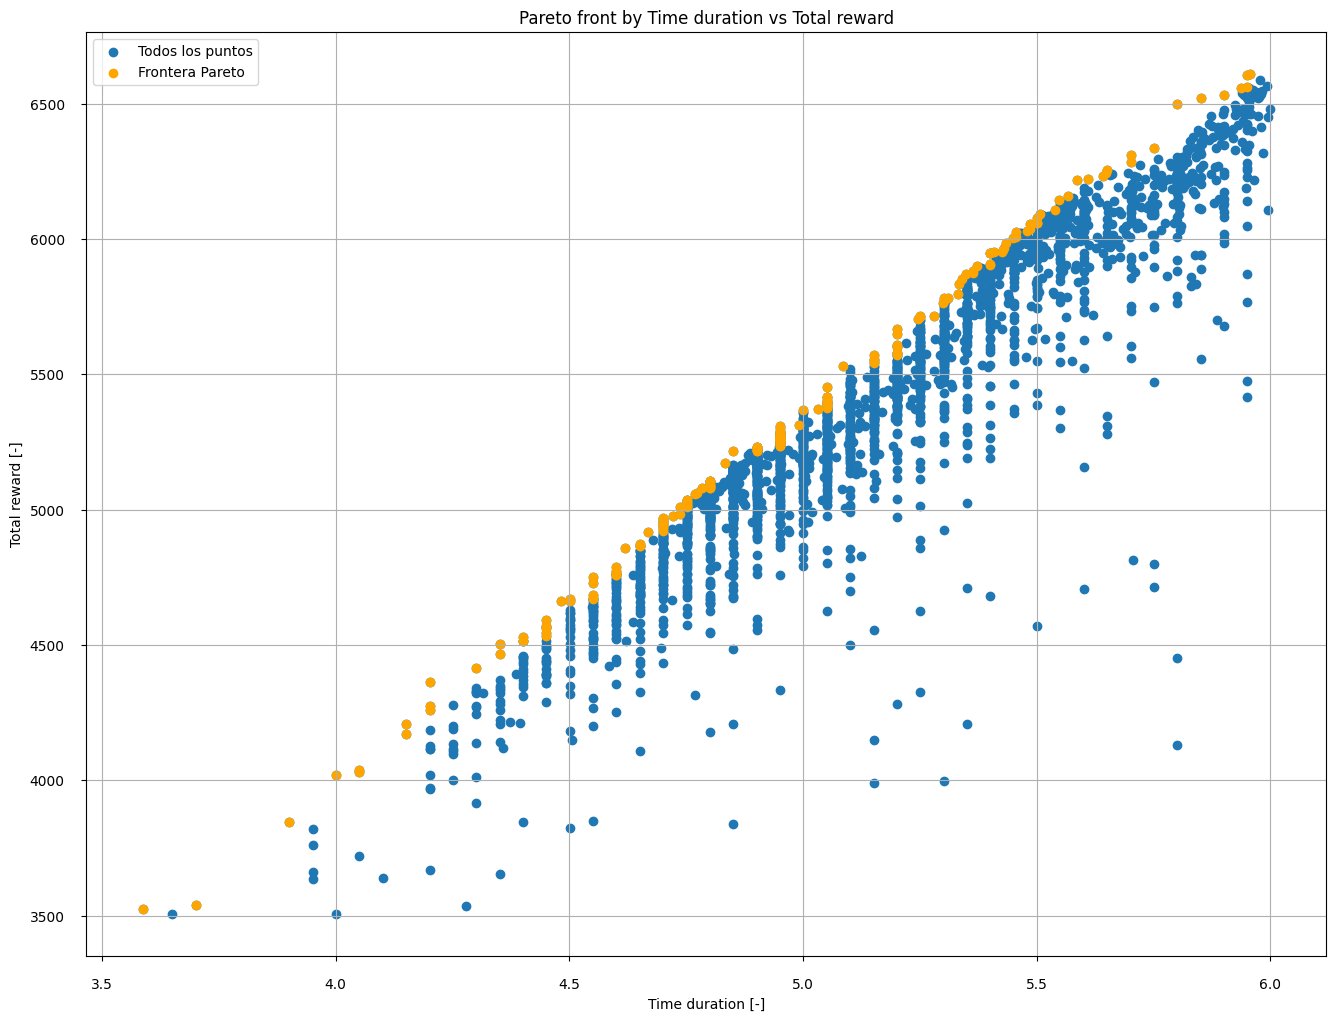

In [131]:
plot_pareto(df2,
            x='time_duration', y='total_reward',
            highlight_color='orange')

In [133]:
df2[df2['pareto_label']=='front_1'].sort_values(["total_reward", "time_duration"], ascending=[False, True])

,episode,epsilon,learning_rate,time_duration,termination_reason,total_reward,performance,final_kp,final_ki,final_kd,pareto_label
1989,1989,0.318054,0.115193,5.957,goal_reached,6610.737743,1109.742780,4.6,0.4,0.2,front_1
3203,3203,0.158125,0.082273,5.951,goal_reached,6608.162922,1110.428990,5.0,0.6,0.2,front_1
2343,2343,0.259418,0.104425,5.951,goal_reached,6562.469233,1102.750669,5.0,0.4,0.0,front_1
4576,4576,0.100000,0.056227,5.938,goal_reached,6557.517907,1104.331072,5.0,0.4,0.0,front_1
3402,3402,0.141010,0.077857,5.901,goal_reached,6533.316042,1107.154049,5.0,0.4,0.0,front_1
...,...,...,...,...,...,...,...,...,...,...,...
2747,2747,0.205589,0.093360,4.051,goal_reached,4029.385704,994.664454,4.6,0.4,0.0,front_1
1387,1387,0.449780,0.136116,4.001,goal_reached,4020.869738,1004.966193,4.4,0.8,0.4,front_1
1401,1401,0.446170,0.135589,3.901,goal_reached,3847.663730,986.327539,4.6,0.8,0.0,front_1
1482,1482,0.425844,0.132578,3.701,goal_reached,3539.338848,956.319602,4.6,0.4,0.0,front_1


In [135]:
df2[df2['pareto_label']=='front_1']['final_kp'].mean()
df2[df2['pareto_label']=='front_1']['final_ki'].mean()
df2[df2['pareto_label']=='front_1']['final_kd'].mean()

4.905418719211823

0.5458128078817734

0.1330049261083744

# Otras Visualizaciones

In [38]:
df2.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration',
       'termination_reason', 'total_reward', 'performance', 'final_kp',
       'final_ki', 'final_kd', 'pareto_label'],
      dtype='object')

In [40]:
#df_num = df2.drop(['termination_reason','pareto_label', 'freq_pareto'],axis=1)
df5 = df2.drop(['termination_reason'],axis=1)
df5.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration', 'total_reward',
       'performance', 'final_kp', 'final_ki', 'final_kd', 'pareto_label'],
      dtype='object')

In [42]:
df5.describe().T

,count,mean,std,min,25%,50%,75%,max
episode,2309.0,3656.383283,848.278039,790.000000,2992.000000,3718.000000,4420.000000,4999.000000
epsilon,2309.0,0.047572,0.046574,0.010000,0.017045,0.032539,0.063504,0.482614
learning_rate,2309.0,0.025578,0.014598,0.010000,0.014145,0.021541,0.033281,0.124508
time_duration,2309.0,4.694029,0.204843,2.720000,4.617000,4.736000,4.797000,4.999000
total_reward,2309.0,8673.228775,484.327815,2941.169949,8560.378212,8748.850886,8872.071352,9500.351428
performance,2309.0,1846.672369,46.242706,956.789183,1845.007145,1854.583639,1856.006368,2007.988621
final_kp,2309.0,4.974968,0.075031,4.400000,5.000000,5.000000,5.000000,5.000000
final_ki,2309.0,4.907059,0.241901,1.600000,4.800000,5.000000,5.000000,5.000000
final_kd,2309.0,2.129667,0.170149,1.000000,2.000000,2.200000,2.200000,3.400000


In [131]:
# ==============================================================================
# Función para Gráfico de Distribución Conjunta (Joint Plot)
# ==============================================================================
def plot_joint_distribution(df, x_col, y_col, hue_col=None,
                            # --- Parámetros de Configuración ---
                            kind='scatter', # 'scatter', 'hist', 'kde'
                            add_contours=False,
                            add_rug=False,
                            title=None, xlabel=None, ylabel=None,
                            figsize=(8, 6), palette='muted',
                            contour_cmap='Reds', marginal_bins=30):
    """
    Genera un gráfico de distribución conjunta con visualizaciones marginales.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        x_col, y_col (str): Columnas para los ejes.
        hue_col (str, optional): Columna para agrupar por color.
        kind (str): Tipo de gráfico principal: 'scatter', 'hist', 'kde'.
        add_contours (bool): Si es True, añade contornos KDE al gráfico principal.
        add_rug (bool): Si es True, añade un rug plot en los márgenes.
        title, xlabel, ylabel (str, optional): Textos del gráfico.
        figsize, palette, contour_cmap, marginal_bins: Parámetros de estilo.
    """
    # --- Configuración de títulos y etiquetas por defecto ---
    final_title = title if title else f'Distribución Conjunta de {y_col} y {x_col}'
    final_xlabel = xlabel if xlabel else x_col.replace('_', ' ').title()
    final_ylabel = ylabel if ylabel else y_col.replace('_', ' ').title()

    # Usamos jointplot como base, pero con un enfoque más manual para superponer
    g = sns.jointplot(data=df, x=x_col, y=y_col, hue=hue_col,
                      kind=kind, height=figsize[0]*1.0, palette=palette)

    g.fig.suptitle(final_title, y=1.02, fontsize=18, weight='bold')
    g.set_axis_labels(final_xlabel, final_ylabel, fontsize=14)

    # --- Lógica de Superposición ---
    if add_contours:
        # Añadir contornos KDE en el gráfico conjunto
        sns.kdeplot(data=df, x=x_col, y=y_col, hue=hue_col,
                    cmap=contour_cmap, thresh=0.05,
                    ax=g.ax_joint, legend=False)

    if add_rug:
        # Añadir rug plots en los ejes marginales
        sns.rugplot(data=df, x=x_col, hue=hue_col, ax=g.ax_joint, legend=False)
        sns.rugplot(data=df, y=y_col, hue=hue_col, ax=g.ax_joint, legend=False)

    plt.tight_layout()
    plt.grid()
    plt.show()

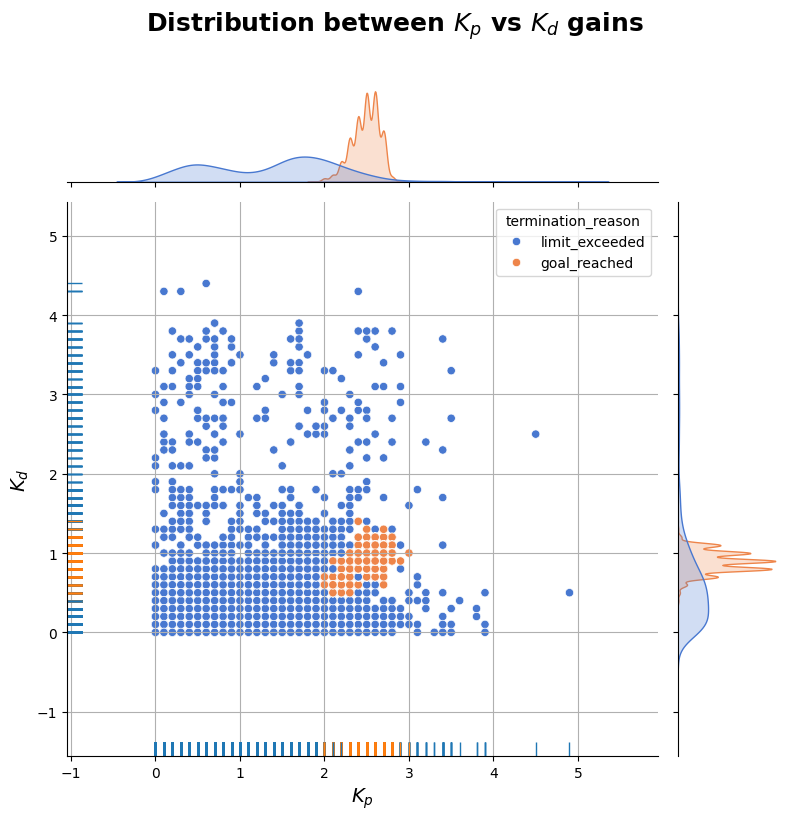

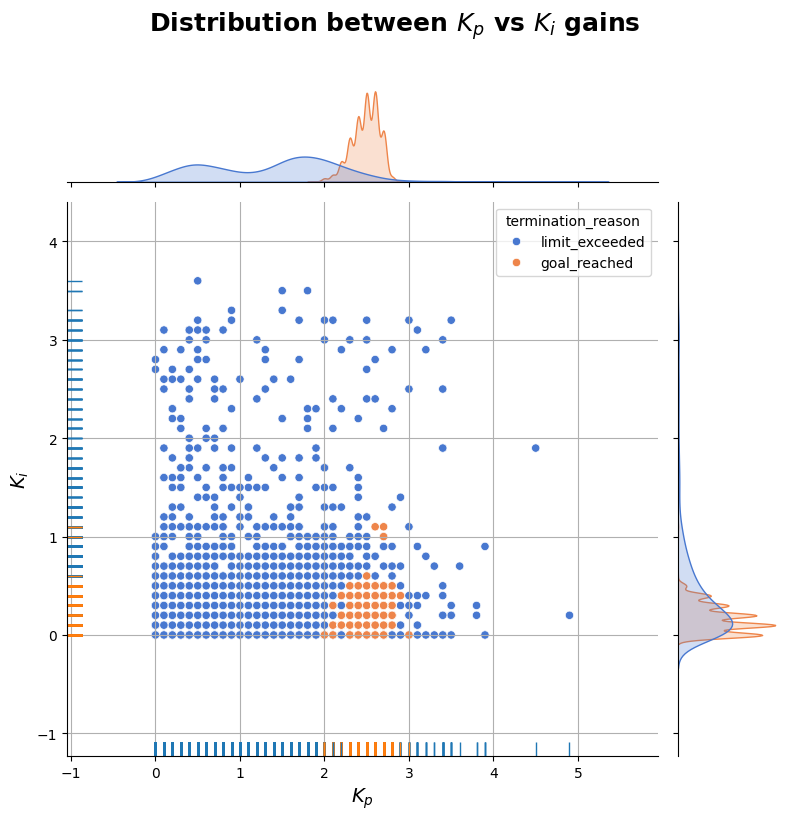

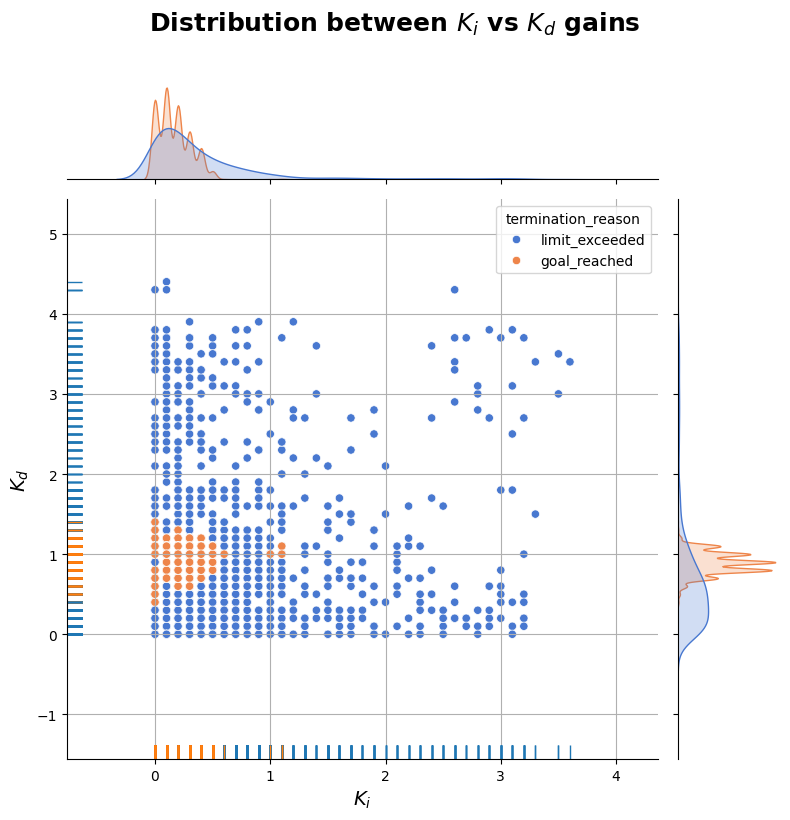

In [167]:
##### Llamada simple
plot_joint_distribution(df=df, x_col='final_kp', y_col='final_kd', add_rug=True, hue_col='termination_reason',
                        title=r'Distribution between $K_p$ vs $K_d$ gains', xlabel=r'$K_p$', ylabel=r'$K_d$')
plot_joint_distribution(df=df, x_col='final_kp', y_col='final_ki', add_rug=True, hue_col='termination_reason',
                        title=r'Distribution between $K_p$ vs $K_i$ gains', xlabel=r'$K_p$', ylabel=r'$K_i$')
plot_joint_distribution(df=df, x_col='final_ki', y_col='final_kd', add_rug=True, hue_col='termination_reason',
                        title=r'Distribution between $K_i$ vs $K_d$ gains', xlabel=r'$K_i$', ylabel=r'$K_d$')

In [137]:
# ==============================================================================
# Función para Superficie de Respuesta 3D/2D (Versión Final)
# ==============================================================================
def plot_3d_surface(df, x_col, y_col, z_col, color_col=None,
                    # --- Parámetros de Configuración de Datos ---
                    interpolation='linear', # 'linear', 'cubic', 'nearest', 'polynomial'
                    poly_degree=1, # 1 para interacción lineal (ax+by+cxy+e), 2 para cuadrático
                    grid_points=100,
                    fixed_vars=None, # Diccionario para fijar variables, e.g., {'kd': 0.03}
                    tolerance=0.1,   # Tolerancia para filtrar 'fixed_vars' (proporción del rango)
                    # --- Parámetros de Configuración de Visualización ---
                    plot_dim='3d', # '3d' o '2d'
                    view_elevation=30, # Ángulo de elevación para vista 3D
                    view_azimuth=-60,  # Ángulo de azimut (rotación) para vista 3D
                    title=None, xlabel=None, ylabel=None, zlabel=None, color_label=None,
                    figsize=(16, 12), cmap='plasma', fig_save_name=None):
    """
    Crea una superficie de respuesta 3D o 2D a partir de una nube de puntos.
    Permite fijar una o más variables para visualizar sub-espacios de alta dimensionalidad.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        x_col, y_col, z_col (str): Columnas para los ejes principales.
        color_col (str, optional): Cuarta variable para mapear al color.
        interpolation (str): 'linear', 'cubic', 'nearest', o 'polynomial'.
        poly_degree (int): 1 para interacción lineal, 2 para cuadrático completo.
        grid_points (int): Resolución de la malla.
        fixed_vars (dict, optional): Diccionario de {nombre_col: valor_fijo} para filtrar los datos.
        tolerance (float): Tolerancia porcentual del rango total para el filtro de 'fixed_vars'.
        plot_dim, view_elevation, ...: Parámetros de visualización y estilo.
    """

    # --- Función Auxiliar para Preparación de la Superficie ---
    def _prepare_surface_data(x, y, z, c, method, degree, points):
        """Prepara los datos de la malla (grid) para la visualización."""
        grid_x, grid_y = np.mgrid[min(x):max(x):complex(0, points),
                                  min(y):max(y):complex(0, points)]

        if method == 'polynomial':
            if degree == 1: # Interacción Lineal: z = c0 + c1x + c2y + c3xy
                A = np.c_[np.ones(len(x)), x, y, x*y]
            elif degree == 2: # Cuadrático Completo: z = c0 + c1x + c2y + c3xy + c4x^2 + c5y^2
                A = np.c_[np.ones(len(x)), x, y, x*y, x**2, y**2]
            else:
                raise NotImplementedError("Solo se implementa el ajuste polinomial de grado 1 y 2.")

            coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)

            xx, yy = grid_x.flatten(), grid_y.flatten()
            if degree == 1:
                A_grid = np.c_[np.ones(len(xx)), xx, yy, xx*yy]
            else:
                A_grid = np.c_[np.ones(len(xx)), xx, yy, xx*yy, xx**2, yy**2]

            grid_z = (A_grid @ coeffs).reshape(grid_x.shape)
        else:
            grid_z = griddata((x, y), z, (grid_x, grid_y), method=method)

        grid_c = None
        if c is not None:
            grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

        return grid_x, grid_y, grid_z, grid_c

    # --- Filtrado de Datos si se especifican variables fijas ---
    data_to_plot = df.copy()
    title_suffix = ""
    if fixed_vars:
        fixed_conditions = []
        for col, val in fixed_vars.items():
            # Calcular el rango de tolerancia
            col_range = data_to_plot[col].max() - data_to_plot[col].min()
            tol_value = col_range * tolerance
            lower_bound = val - tol_value
            upper_bound = val + tol_value
            data_to_plot = data_to_plot[data_to_plot[col].between(lower_bound, upper_bound)]
            fixed_conditions.append(f"{col} ≈ {val:.2f}")

        if data_to_plot.empty:
            raise ValueError(f"No quedan datos después de filtrar con fixed_vars={fixed_vars}. "
                             "Intente aumentar la 'tolerance'.")

        title_suffix = f"\n(con {', '.join(fixed_conditions)})"

    # --- Preparación de Datos Principal ---
    x_data = data_to_plot[x_col].values
    y_data = data_to_plot[y_col].values
    z_data = data_to_plot[z_col].values
    c_data = data_to_plot[color_col].values if color_col else None

    grid_x, grid_y, grid_z, grid_c = _prepare_surface_data(
        x_data, y_data, z_data, c_data,
        interpolation, poly_degree, grid_points
    )

    # --- Configuración de Títulos y Etiquetas ---
    final_title = (title if title else f'Superficie de Respuesta para {z_col}') + title_suffix
    final_xlabel = xlabel if xlabel else x_col.replace('_', ' ').title()
    final_ylabel = ylabel if ylabel else y_col.replace('_', ' ').title()
    final_zlabel = zlabel if zlabel else z_col.replace('_', ' ').title()
    final_color_label = color_label if color_label else (color_col.replace('_', ' ').title() if color_col else '')

    # --- Lógica de Ploteo ---
    fig = plt.figure(figsize=figsize)
    plt.rcParams['xtick.major.pad'] = 12
    plt.rcParams['ytick.major.pad'] = 12

    if plot_dim == '3d':
        ax = fig.add_subplot(111, projection='3d')
        facecolors = None
        if grid_c is not None:
            valid_mask = ~np.isnan(grid_c)
            norm = plt.Normalize(np.nanmin(grid_c), np.nanmax(grid_c))
            facecolors = plt.get_cmap(cmap)(norm(grid_c))
            facecolors[~valid_mask] = [0, 0, 0, 0]
        surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=cmap if facecolors is None else None,
                               facecolors=facecolors, rstride=1, cstride=1, antialiased=False, linewidth=0)
        ax.set_xlabel(final_xlabel, fontsize=16, labelpad=10)
        ax.set_ylabel(final_ylabel, fontsize=16, labelpad=10)
        ax.set_zlabel(final_zlabel, fontsize=16, labelpad=10)
        if color_col:
            mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            mappable.set_array(grid_c[valid_mask])
            cbar = fig.colorbar(mappable, shrink=0.6, aspect=10, pad=0.1)
            cbar.set_label(final_color_label, fontsize=16, labelpad=10)
        ax.view_init(elev=view_elevation, azim=view_azimuth)

    elif plot_dim == '2d':
        ax = fig.add_subplot(111)
        contour_data = grid_c if color_col else grid_z
        cbar_label = final_color_label if color_col else final_zlabel
        contour = ax.contourf(grid_x, grid_y, contour_data, levels=20, cmap=cmap)
        cbar = fig.colorbar(contour, ax=ax, shrink=0.9)
        cbar.set_label(cbar_label, fontsize=26, labelpad=10)
        cbar.ax.tick_params(labelsize=20)
        ax.set_xlabel(final_xlabel, fontsize=28, labelpad=10)
        ax.set_ylabel(final_ylabel, fontsize=28, labelpad=10)
        if color_col:
            ax.contour(grid_x, grid_y, grid_z, colors='black', linestyles='dashed', levels=10)
    else:
        raise ValueError("plot_dim debe ser '3d' o '2d'")
    
    ax.set_title(final_title, fontsize=30, pad=10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.tight_layout()
    plt.show()
    if fig_save_name is not None:
        fig.savefig(f"{fig_save_name}.png", bbox_inches='tight')

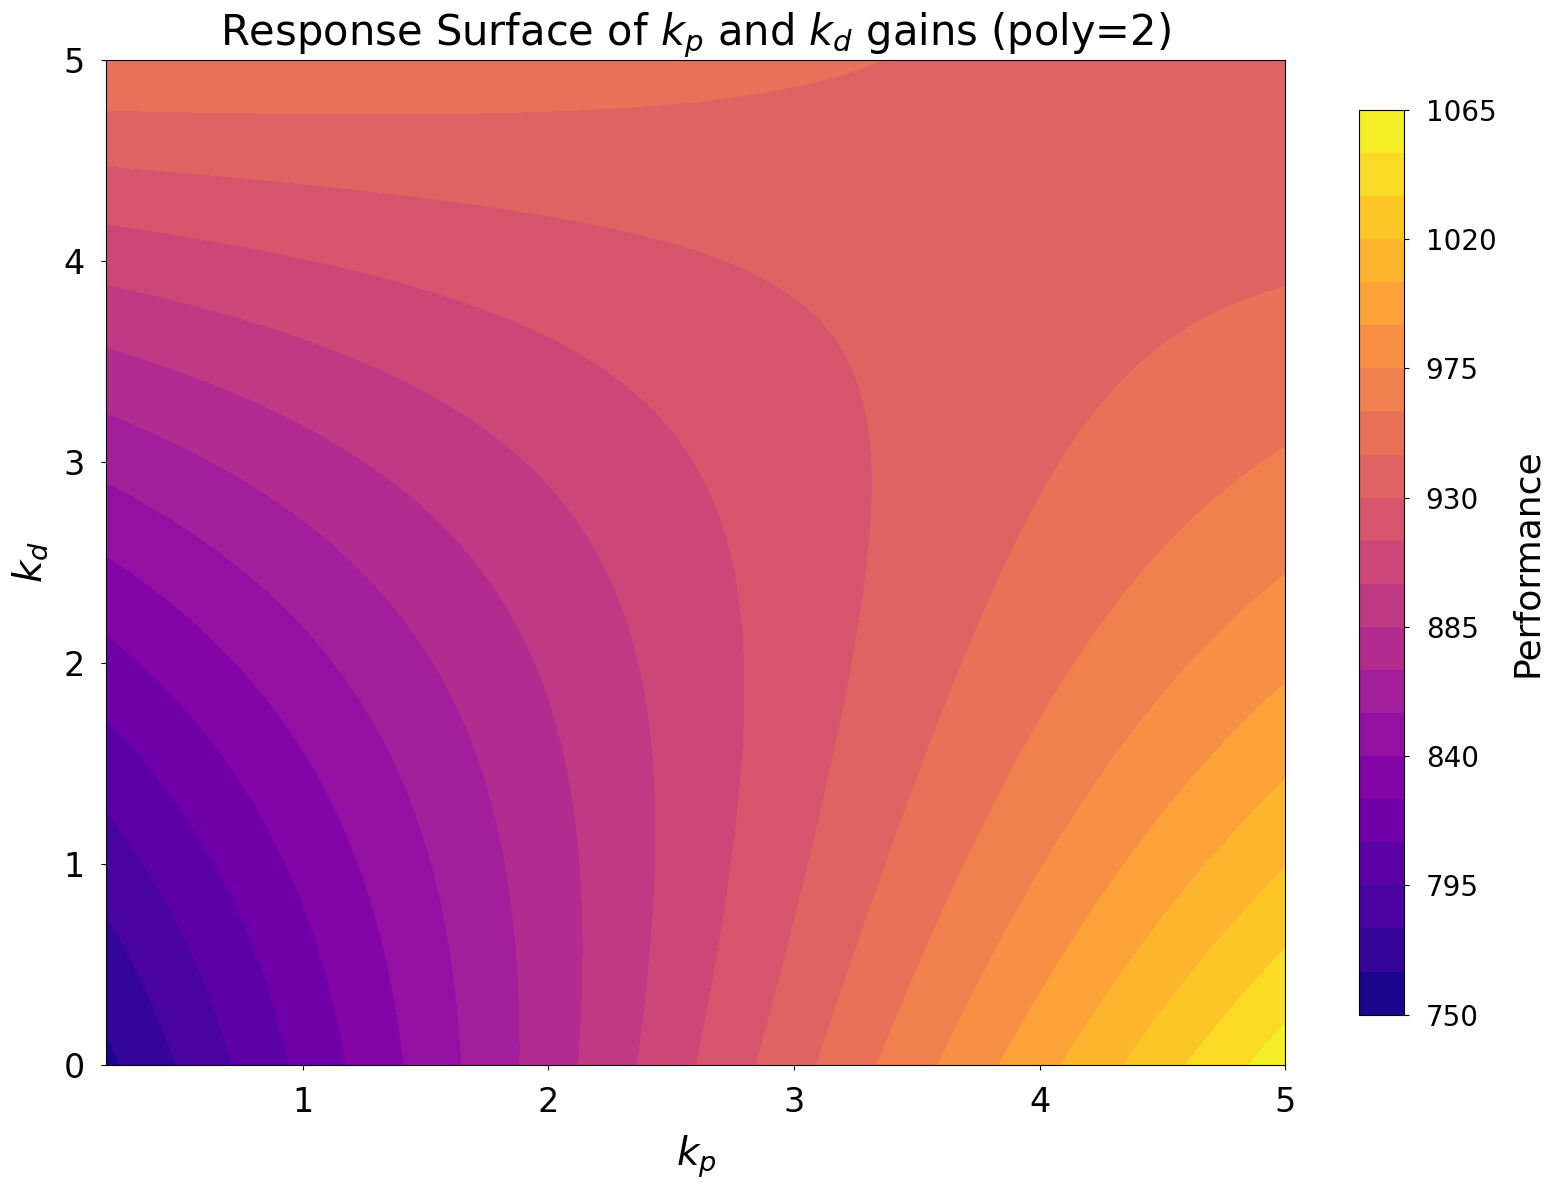

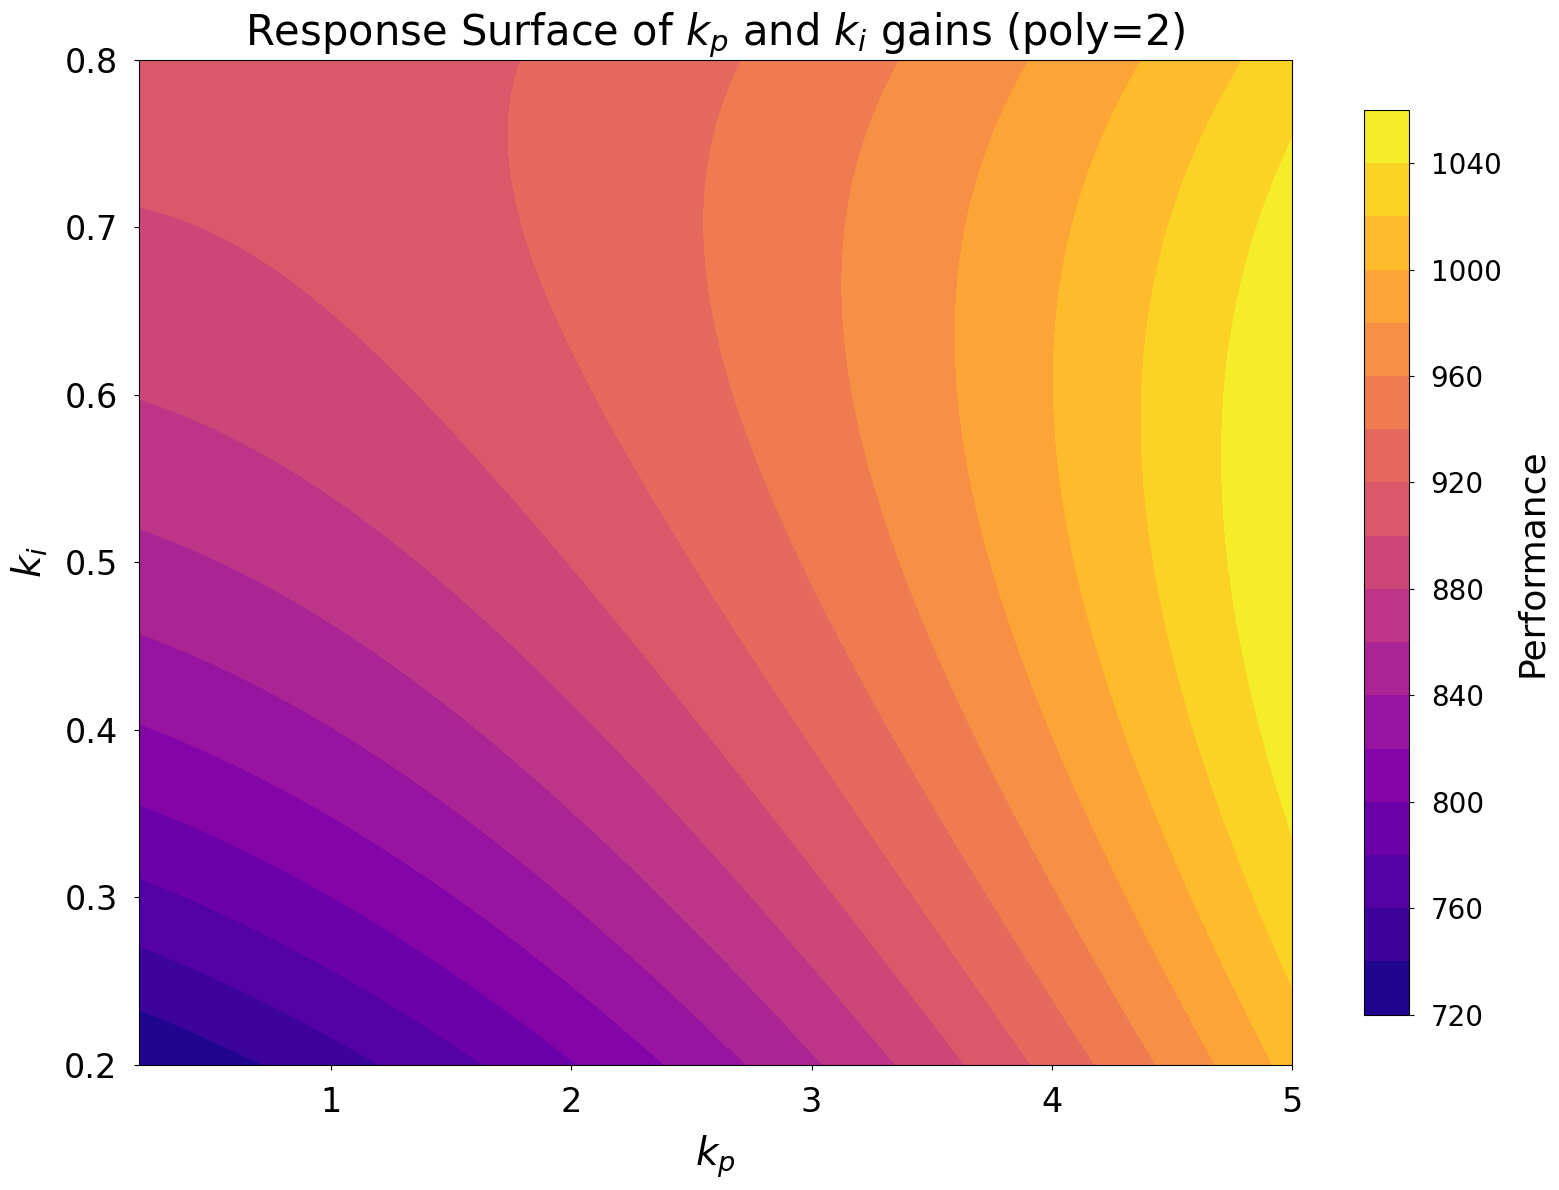

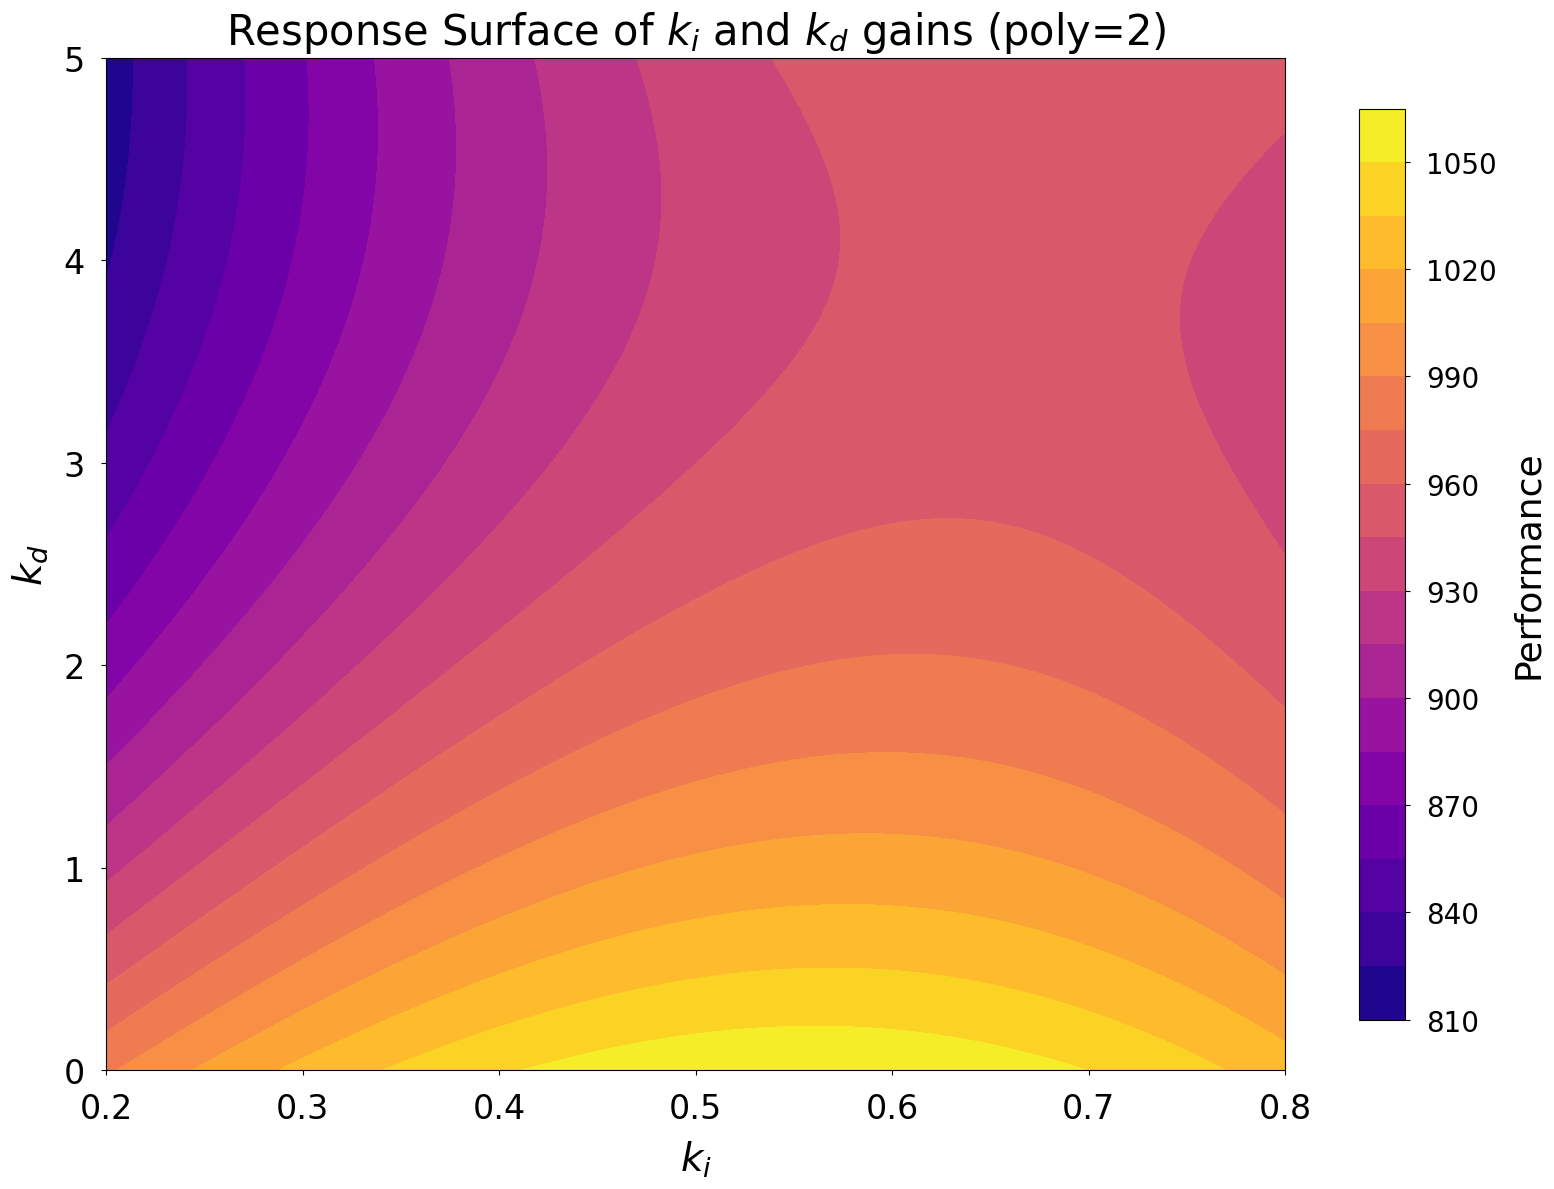

In [139]:
#ki_25 = df['final_ki'].quantile(0.25)
plot_3d_surface(df=df2,
                x_col='final_kp', y_col='final_kd', z_col='performance',
                interpolation='polynomial', # 'linear', 'cubic', 'nearest', o 'polynomial'
                poly_degree=2,
                plot_dim='2d',
                #fixed_vars={'final_ki': ki_25},
                #tolerance=0.2, # Usar 20% del rango de fixed_vars para obtener suficientes puntos
                title=r'Response Surface of $k_p$ and $k_d$ gains (poly=2)', xlabel=r'$k_p$', ylabel=r'$k_d$', fig_save_name='resp_surf_Kp_kd_2')
plot_3d_surface(df=df2,
                x_col='final_kp', y_col='final_ki', z_col='performance',
                interpolation='polynomial', # 'linear', 'cubic', 'nearest', o 'polynomial'
                poly_degree=2,
                plot_dim='2d',
                #fixed_vars={'final_kp': kp_50},
                #tolerance=0.2, # Usar 20% del rango de fixed_vars para obtener suficientes puntos
                title=r'Response Surface of $k_p$ and $k_i$ gains (poly=2)', xlabel=r'$k_p$', ylabel=r'$k_i$', fig_save_name='resp_surf_Kp_ki_2')
plot_3d_surface(df=df2,
                x_col='final_ki', y_col='final_kd', z_col='performance',
                interpolation='polynomial', # 'linear', 'cubic', 'nearest', o 'polynomial'
                poly_degree=2,
                plot_dim='2d',
                #fixed_vars={'final_kp': kp_75},
                #tolerance=0.2, # Usar 20% del rango de fixed_vars para obtener suficientes puntos
                title=r'Response Surface of $k_i$ and $k_d$ gains (poly=2)', xlabel=r'$k_i$', ylabel=r'$k_d$', fig_save_name='resp_surf_Ki_kd_2')

# PARTE 2: Q TABLAS

In [80]:
name_q_files = 'agent_state_final_tables.xlsx'
kp_q_table_sheet = 'q_tables_kp'
ki_q_table_sheet = 'q_tables_ki'
kd_q_table_sheet = 'q_tables_kd'

df_q_table_kp = pd.read_excel(folder_name+name_q_files, sheet_name=kp_q_table_sheet, index_col=kp_q_table_sheet[-2:])
df_q_table_ki = pd.read_excel(folder_name+name_q_files, sheet_name=ki_q_table_sheet, index_col=ki_q_table_sheet[-2:])
df_q_table_kd = pd.read_excel(folder_name+name_q_files, sheet_name=kd_q_table_sheet, index_col=kd_q_table_sheet[-2:])
print(f"Tamaño de la Q-table kp: {df_q_table_kp.shape}")
print(f"Tamaño de la Q-table ki: {df_q_table_ki.shape}")
print(f"Tamaño de la Q-table kd: {df_q_table_kd.shape}")

Tamaño de la Q-table kp: (26, 3)
Tamaño de la Q-table ki: (26, 3)
Tamaño de la Q-table kd: (26, 3)


In [82]:
df_q_table_kp = df_q_table_kp.set_index(df_q_table_kp.index.round(1))
df_q_table_kp = df_q_table_kp.rename(columns={'action_0':'↓', 'action_1':'↓↑', 'action_2':'↑'})
df_q_table_ki = df_q_table_ki.set_index(df_q_table_ki.index.round(1))
df_q_table_ki = df_q_table_ki.rename(columns={'action_0':'↓', 'action_1':'↓↑', 'action_2':'↑'})
df_q_table_kd = df_q_table_kd.set_index(df_q_table_kd.index.round(1))
df_q_table_kd = df_q_table_kd.rename(columns={'action_0':'↓', 'action_1':'↓↑', 'action_2':'↑'})

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects as path_effects

def plot_q_table_heatmap(q_table_df,
                         title='Q-Table',
                         xlabel='Acciones',
                         ylabel='Estados',
                         figsize=(4, 14),
                         cmap='coolwarm',
                         annot=False,
                         fmt=".2f",
                         cell_edgewidth=0.5,
                         x_marker='X',
                         x_kwargs=None,
                         fig_save_name=None):
    """
    Heatmap de la Q-table marcando con una X la acción óptima en cada estado.

    Args:
        q_table_df (pd.DataFrame): índices=estados, columnas=acciones.
        title, xlabel, ylabel, figsize, cmap, annot, fmt: igual que antes.
        cell_edgewidth (float): grosor uniforme de bordes de celda.
        x_marker (str): símbolo para marcar la acción óptima.
        x_kwargs (dict): kwargs para el texto de la X (color, fontsize, weight…).
    """
    if x_kwargs is None:
        x_kwargs = dict(color='white', fontsize=8, #weight='bold',
                        path_effects=[path_effects.withStroke(linewidth=1.5, foreground='black')])

    vals = q_table_df.values
    n_states, n_actions = vals.shape

    fig, ax = plt.subplots(figsize=figsize)
    # fondo de colores y bordes uniformes
    c = ax.pcolormesh(vals, cmap=cmap, edgecolors='white', linewidth=cell_edgewidth)
    cb = fig.colorbar(c, ax=ax, shrink=0.8)
    cb.set_label('Q-values', fontsize=14, labelpad=10)

    # opcional: anotar valor Q
    if annot:
        for i in range(n_states):
            for j in range(n_actions):
                ax.text(j+0.5, i+0.5, f"{vals[i, j]:{fmt}}",
                        ha='center', va='center',
                        color='white', fontsize=8,
                        path_effects=[path_effects.withStroke(linewidth=1.5, foreground='black')])

    # marcar acción óptima con X
    best_idx = np.argmax(vals, axis=1)
    for i, j in enumerate(best_idx):
        ax.text(j+0.5, i+0.62, x_marker,
                ha='center', va='center',
                **x_kwargs)

    # configuración de ejes
    ax.set_title(title, fontsize=18, pad=10)
    ax.set_xlabel(xlabel, fontsize=16, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=10)
    ax.set_xticks(np.arange(n_actions)+0.5)
    ax.set_xticklabels(q_table_df.columns, fontsize=14)
    ax.set_yticks(np.arange(n_states)+0.5)
    ax.set_yticklabels(q_table_df.index, fontsize=12)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    if fig_save_name is not None:
        fig.savefig(f"{fig_save_name}.png", bbox_inches='tight')

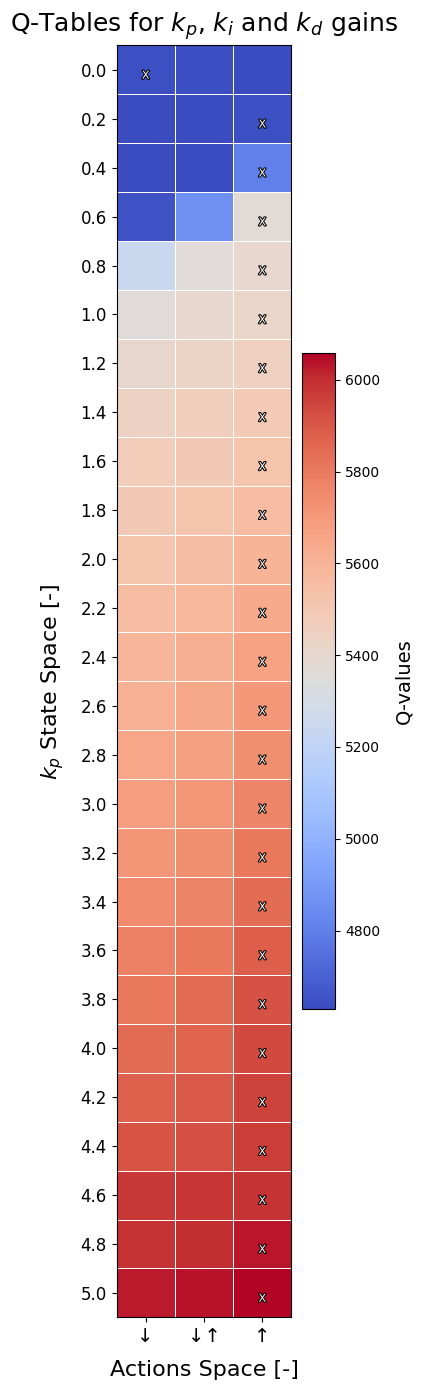

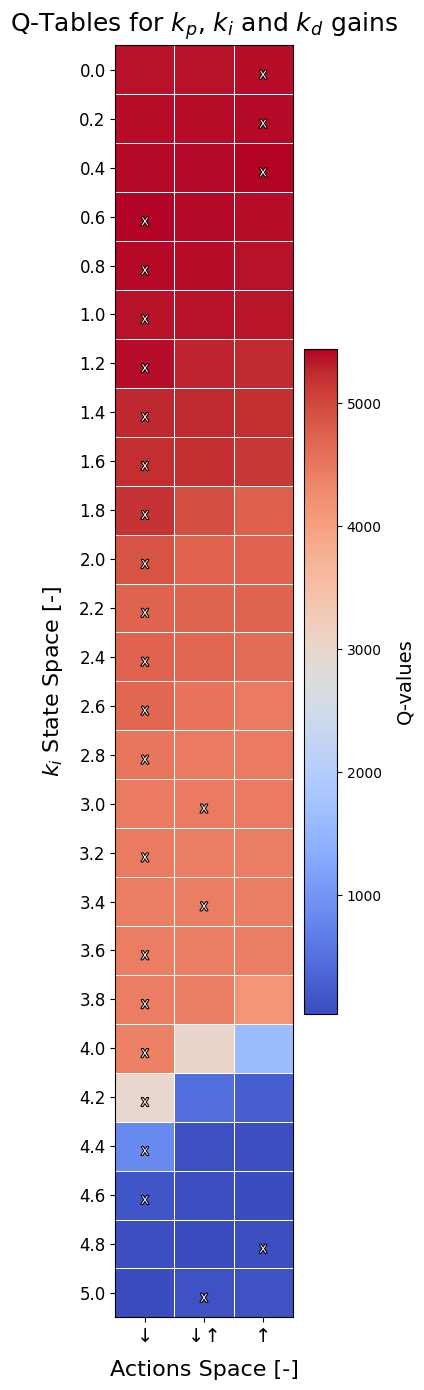

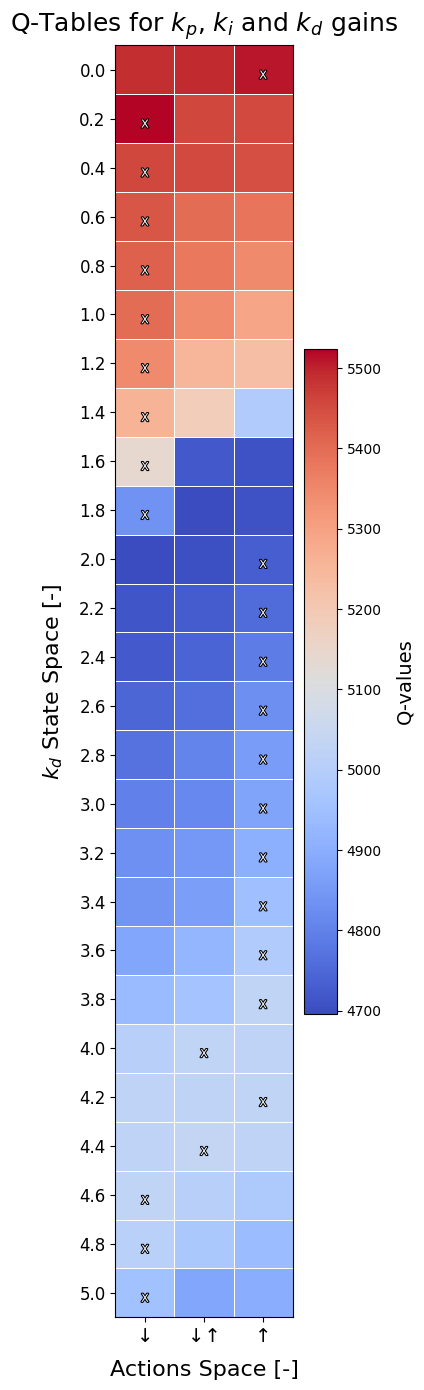

In [86]:
plot_q_table_heatmap(df_q_table_kp,
                     title= r'Q-Tables for $k_p$, $k_i$ and $k_d$ gains',
                     xlabel= 'Actions Space [-]',
                     ylabel= r'$k_p$ State Space [-]',
                     annot=False,
                     fig_save_name='q_table_kp')
plot_q_table_heatmap(df_q_table_ki,
                     title= r'Q-Tables for $k_p$, $k_i$ and $k_d$ gains',
                     xlabel= 'Actions Space [-]',
                     ylabel= r'$k_i$ State Space [-]',
                     annot=False,
                     fig_save_name='q_table_ki')
plot_q_table_heatmap(df_q_table_kd,
                     title= r'Q-Tables for $k_p$, $k_i$ and $k_d$ gains',
                     xlabel= 'Actions Space [-]',
                     ylabel= r'$k_d$ State Space [-]',
                     annot=False,
                     fig_save_name='q_table_kd')